# LATE推定_分散削減

## セッティング
- 前提
    - ECサイトにて、とあるエントリー制の施策が実施されており、下記のようにランダムでTr・Crが割り当てられて訴求されているものとする
        - Treatment: 画面内で訴求が行われる
        - Contorl  : 訴求が行われない

## モジュールインポート

In [138]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm
from linearmodels.iv import IV2SLS

## 関数定義

データ生成とLATE推定のコードはうとしんさんの[こちらの記事](https://qiita.com/s1ok69oo/items/d9f3a3860388f3b9911d)を参考にさせていただきました

In [139]:
def generate_data(random_seed: int, data_size: int):
    '''効果検証対象となるデータを作成する
       └施策の訴求: 訴求有無を設定し、ユーザーごとにランダムでどちらかを割り当てる
        ├Treatment(T=1): 訴求が行われる
        └Contorl  (T=0): 訴求が行われない
    Args:
        random_seed (int): 乱数のシード値
        data_size   (int): データの行数

    Returns:
        df: 効果検証対象となるデータフレーム
            ├X: 特徴量（サイト回遊意欲・購入意欲の高さを示す交絡因子）
            ├Z : バナー訴求有無（Treatmentは1、Controlは0）
            ├D : バナー閲覧有無
            └Y : 購入有無
    '''

    np.random.seed(random_seed)
    size = data_size
    
    # サイト回遊意欲・購入意欲の高さ: X0は未観測で、X0とX1によって効果修飾が行われるものとする
    X0 = np.random.uniform(0, 5, size=size)
    X1 = np.random.uniform(0, 5, size=size)
    X2 = np.random.uniform(0, 5, size=size)
    
    # 訴求有無: ランダムで訴求2パターンが割り当てられるものとする（Treatmentは1、Controlは0）
    Z = np.array([])
    for i in range(size):
        Z_i = np.random.choice(2, size=1, p=[0.5, 0.5])[0]
        Z = np.append(Z, Z_i)
    
    # バナー閲覧確率: サイト回遊意欲・購入意欲とバナーの影響で施策認知確率も高くなるものとする
    # d_prob = (X0 + X1 + X2) / 30 + 0.1 * Z + np.random.uniform(-0.03, 0.03, size=size) # バナーによる施策認知への効果: 0.1
    d_prob = (X0 + X1 + X2) / 30 + 0.3 * Z # バナーによる施策認知への効果: 0.3
    d_prob = np.clip(d_prob, 0, 1)
    D = np.array([])
    for i in range(size):
        D_i = np.random.choice(2, size=1, p=[1-d_prob[i], d_prob[i]])[0]
        D = np.append(D, D_i)

    # 購入の有無: サイト回遊意欲・購入意欲が高いほど、購入確率も高く、またバナー閲覧により購入確率が上がるものとする
    # y_prob = (X0 + X1 + X2) / 30 + np.random.uniform(-0.05, 0.05, size=size)
    y_prob = (X0 + X1 + X2) / 30
    y_prob = np.clip(y_prob, 0, 1)
    Y0 = np.array([])
    for i in range(size):
        Y_i = np.random.choice(2, size=1, p=[1-y_prob[i], y_prob[i]])[0]
        Y0 = np.append(Y0, Y_i)

    # y_prob = (X0 + X1 + X2) / 30 + np.random.uniform(-0.05, 0.05, size=size) + 0.15 * D # バナー閲覧による購入への効果: 0.15 x [0.0~1.5]
    y_prob = (X0 + X1 + X2) / 30 + 0.3 * D # バナー閲覧による購入への効果: 0.3 x [0.0~1.5]
    y_prob = np.clip(y_prob, 0, 1)
    Y1 = np.array([])
    for i in range(size):
        Y_i = np.random.choice(2, size=1, p=[1-y_prob[i], y_prob[i]])[0]
        Y1 = np.append(Y1, Y_i)
    
    df = pd.DataFrame({'X0': X0, 'X1': X1, 'X2': X2, 'Z': Z, 'D': D, 'Y0': Y0, 'Y1': Y1}).astype('float')
    df['Y'] = df['D'] * df['Y1'] + (1-df['D']) * df['Y0']
    
    return df

In [140]:
def generate_hte_data(random_seed: int, data_size: int):
    '''効果検証対象となるデータを作成する
       └施策の訴求: 訴求有無を設定し、ユーザーごとにランダムでどちらかを割り当てる
        ├Treatment(T=1): 訴求が行われる
        └Contorl  (T=0): 訴求が行われない
    Args:
        random_seed (int): 乱数のシード値
        data_size   (int): データの行数

    Returns:
        df: 効果検証対象となるデータフレーム
            ├X: 特徴量（サイト回遊意欲・購入意欲の高さを示す交絡因子）
            ├Z : バナー訴求有無（Treatmentは1、Controlは0）
            ├D : バナー閲覧有無
            └Y : 購入有無
    '''

    np.random.seed(random_seed)
    size = data_size
    
    # サイト回遊意欲・購入意欲の高さ: X0は未観測で、X0とX1によって効果修飾が行われるものとする
    X0 = np.random.uniform(0, 5, size=size)
    X1 = np.random.uniform(0, 5, size=size)
    X2 = np.random.uniform(0, 5, size=size)
    
    # 訴求有無: ランダムで訴求2パターンが割り当てられるものとする（Treatmentは1、Controlは0）
    Z = np.array([])
    for i in range(size):
        Z_i = np.random.choice(2, size=1, p=[0.5, 0.5])[0]
        Z = np.append(Z, Z_i)
    
    # バナー閲覧確率: サイト回遊意欲・購入意欲とバナーの影響で施策認知確率も高くなるものとする
    d_prob = (X0 + X1 + X2) / 30 + 0.1 * Z + np.random.uniform(-0.03, 0.03, size=size) # バナーによる施策認知への効果: 0.1
    d_prob = np.clip(d_prob, 0, 1)
    D = np.array([])
    for i in range(size):
        D_i = np.random.choice(2, size=1, p=[1-d_prob[i], d_prob[i]])[0]
        D = np.append(D, D_i)

    # 購入の有無: サイト回遊意欲・購入意欲が高いほど、購入確率も高く、またバナー閲覧により購入確率が上がるものとする
    # y_prob = (X0 + X1 + X2) / 30 + np.random.uniform(-0.05, 0.05, size=size)
    y_prob = (X0 + X1 + X2) / 30
    y_prob = np.clip(y_prob, 0, 1)
    Y0 = np.array([])
    for i in range(size):
        Y_i = np.random.choice(2, size=1, p=[1-y_prob[i], y_prob[i]])[0]
        Y0 = np.append(Y0, Y_i)

    # y_prob = (X0 + X1 + X2) / 30 + np.random.uniform(-0.05, 0.05, size=size) + 0.15 * D * ((X0 + X1)/10) # バナー閲覧による購入への効果: 0.15 x [0.0~1.5]
    y_prob = (X0 + X1 + X2) / 30 + 0.15 * D * ((X0 + X1)/10) # バナー閲覧による購入への効果: 0.15 x [0.0~1.5]
    y_prob = np.clip(y_prob, 0, 1)
    Y1 = np.array([])
    for i in range(size):
        Y_i = np.random.choice(2, size=1, p=[1-y_prob[i], y_prob[i]])[0]
        Y1 = np.append(Y1, Y_i)
    
    df = pd.DataFrame({'X0': X0, 'X1': X1, 'X2': X2, 'Z': Z, 'D': D, 'Y0': Y0, 'Y1': Y1}).astype('float')
    df['Y'] = df['D'] * df['Y1'] + (1-df['D']) * df['Y0']
    
    return df

In [141]:
def calculate_true_late(df: pd.DataFrame):
    '''真のLATEを算出
    
    Args:
        df(pd.DataFrame): 効果検証対象となるデータフレーム

    Returns:
        true_late

    '''
    true_late = (df[df['D']==1]['Y1'] - df[df['D']==1]['Y0']).mean()
    
    return true_late

In [142]:
def calculate_late_estimator(df: pd.DataFrame):
    '''LATE推定量を算出
    
    Args:
        df(pd.DataFrame): 効果検証対象となるデータフレーム

    Returns:
        late_estimator

    '''
    E_Y_Z_1 = df[df['Z']==1]['Y'].mean()
    E_Y_Z_0 = df[df['Z']==0]['Y'].mean()
    E_D_Z_1 = df[df['Z']==1]['D'].mean()
    E_D_Z_0 = df[df['Z']==0]['D'].mean()
    late_estimator = (E_Y_Z_1 - E_Y_Z_0) / (E_D_Z_1 - E_D_Z_0)

    return late_estimator

In [143]:
def calculate_iv_estimator(df: pd.DataFrame):
    '''操作変数推定量を算出
    
    Args:
        df(pd.DataFrame): 効果検証対象となるデータフレーム

    Returns:
        iv_estimator

    '''
    average_z = df['Z'].mean()
    average_y = df['Y'].mean()
    average_d = df['D'].mean()
    beta_hat_1_iv = np.sum((df['Z'] - average_z) * (df['Y'] - average_y)) / np.sum((df['Z'] - average_z) * (df['D'] - average_d))
    iv_estimator = beta_hat_1_iv
    
    return iv_estimator

## LATE推定量（と操作変数推定量）のシミュレーションを行う

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


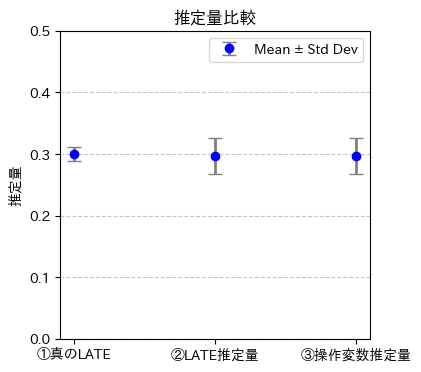

In [144]:
data_size = 10000
n_trials = 100

true_late_list = []
late_estimator_list = []
iv_estimator_list = []
for i in tqdm(range(n_trials)):
    df = generate_data(random_seed=i, data_size=data_size)
    true_late = calculate_true_late(df)
    true_late_list.append(true_late)
    late_estimator = calculate_late_estimator(df)
    late_estimator_list.append(late_estimator)
    iv_estimator = calculate_iv_estimator(df)
    iv_estimator_list.append(iv_estimator)

# 算出LATEの平均・標準偏差を取得する
avg_list = []
avg_list.append(np.mean(true_late_list))
avg_list.append(np.mean(late_estimator_list))
avg_list.append(np.mean(iv_estimator_list))
std_list = []
std_list.append(np.std(true_late_list))
std_list.append(np.std(late_estimator_list))
std_list.append(np.std(iv_estimator_list))

# 凡例を設定
categories = ['①真のLATE', '②LATE推定量', '③操作変数推定量', '④', '⑤']
categories = categories[0: len(avg_list)]

# 比較結果を描画
plt.figure(figsize=(4, 4))
# 点とエラーバーを描画
plt.errorbar(
    categories,
    avg_list,
    yerr=std_list,
    fmt='o',  # 点のマーカー
    color='blue',  # 点の色
    ecolor='gray',  # エラーバーの色
    elinewidth=2,  # エラーバーの線幅
    capsize=5,  # エラーバーの端の長さ
    label='Mean ± Std Dev'
)
plt.title('推定量比較')
plt.ylabel('推定量')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.ylim(0, 0.5)
plt.show()

## ライブラリで計算してみる: 説明変数Xの情報を入れることで分散削減できるのでは？

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]


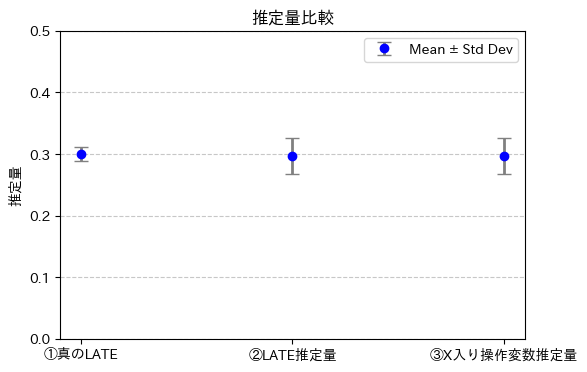

In [145]:
data_size = 10000
n_trials = 100

true_late_list = []
late_estimator_list = []
ivmodule_estimator_list = []
for i in tqdm(range(n_trials)):
    df = generate_data(random_seed=i, data_size=data_size)
    true_late = calculate_true_late(df)
    true_late_list.append(true_late)
    late_estimator = calculate_late_estimator(df)
    late_estimator_list.append(late_estimator)
    iv = IV2SLS.from_formula("Y ~ 1 + X0 + X1 + X2 [D ~ Z]", df).fit()
    ivmodule_estimator = iv.params['D']
    ivmodule_estimator_list.append(ivmodule_estimator)

# 算出LATEの平均・標準偏差を取得する
avg_list = []
avg_list.append(np.mean(true_late_list))
avg_list.append(np.mean(late_estimator_list))
avg_list.append(np.mean(ivmodule_estimator_list))
std_list = []
std_list.append(np.std(true_late_list))
std_list.append(np.std(late_estimator_list))
std_list.append(np.std(ivmodule_estimator_list))

# 凡例を設定
categories = ['①真のLATE', '②LATE推定量', '③X入り操作変数推定量', '④', '⑤']
categories = categories[0: len(avg_list)]

# 比較結果を描画
plt.figure(figsize=(6, 4))
# 点とエラーバーを描画
plt.errorbar(
    categories,
    avg_list,
    yerr=std_list,
    fmt='o',  # 点のマーカー
    color='blue',  # 点の色
    ecolor='gray',  # エラーバーの色
    elinewidth=2,  # エラーバーの線幅
    capsize=5,  # エラーバーの端の長さ
    label='Mean ± Std Dev'
)
plt.title('推定量比較')
plt.ylabel('推定量')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.ylim(0, 0.5)
plt.show()

Xを使っても分散削減は難しかったのか？

## 分散の計算を行なってみる

### LATE推定量

In [146]:
data_size = 10000
n_trials = 100
se_list = []
for i in tqdm(range(n_trials)):
    df = generate_data(random_seed=i, data_size=data_size)
    true_late = calculate_true_late(df)
    # print(f'真のLATE: {true_late}')
    late_estimator = calculate_late_estimator(df)
    # print(f'LATE推定量: {late_estimator}')
    # 二乗誤差: LATE推定量は不偏推定量なので、二乗誤差 = 分散
    se = (late_estimator - true_late)**2
    # print(f'二乗誤差: {se}')
    se_list.append(se)

# 平均二乗誤差を計算する
mse = np.mean(se_list)
mse

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


0.0008853296766551072

### 操作変数推定量_formula改善

In [147]:
data_size = 10000
n_trials = 100
se_list = []
for i in tqdm(range(n_trials)):
    df = generate_data(random_seed=i, data_size=data_size)
    true_late = calculate_true_late(df)
    # print(f'真のLATE: {true_late}')
    iv = IV2SLS.from_formula("Y ~ 1 + X0 + X1 + X2 +[D ~ Z]", df).fit()
    ivmodule_estimator = iv.params['D']
    # print(f'LATE推定量: {late_estimator}')
    # 二乗誤差: LATE推定量は不偏推定量なので、二乗誤差 = 分散
    se = (ivmodule_estimator - true_late)**2
    # print(f'二乗誤差: {se}')
    se_list.append(se)

# 平均二乗誤差を計算する
mse = np.mean(se_list)
mse

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.85it/s]


0.000882975786587848

### 操作変数推定量_formula改善②

In [148]:
data_size = 10000
n_trials = 100
se_list = []
for i in tqdm(range(n_trials)):
    df = generate_data(random_seed=i, data_size=data_size)
    true_late = calculate_true_late(df)
    # print(f'真のLATE: {true_late}')
    iv = IV2SLS.from_formula("Y ~ 1 + [D ~ Z+ X0 + X1 + X2]", df).fit()
    ivmodule_estimator = iv.params['D']
    # print(f'LATE推定量: {late_estimator}')
    # 二乗誤差: LATE推定量は不偏推定量なので、二乗誤差 = 分散
    se = (ivmodule_estimator - true_late)**2
    # print(f'二乗誤差: {se}')
    se_list.append(se)

# 平均二乗誤差を計算する
mse = np.mean(se_list)
mse

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.85it/s]


0.055936208197911085